<a href="https://colab.research.google.com/github/dsethia1/ASD_Diagnosis/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


#DATA SET UP

In [ ]:
import pandas as pd
import numpy as np
import csv
import collections

In [ ]:
#from demo_data create map where each ID associated with 0(NT) or 1(ASD)
ID = {}
ID_reader = pd.read_csv('DemoData.csv', nrows=159, header=None)
line = 0
id_col = 0
diag_col = 1
for header,row in ID_reader.iterrows():
    if line == 0:
        print("processing")
    else:
        if(row[diag_col] == 'TD'):
            ID[row[id_col]] = 0
        else:
            ID[row[id_col]] = 1
    line += 1

processing


In [ ]:
#add colomn to eGeMAPS_us with 0 or 1 score using ID label
us_reader = pd.read_csv('egemaps_us.csv', nrows = 328, header=0)
diag_chart_us = []
for header, row in us_reader.iterrows():
    diag_chart_us.append(ID[row["ID"]])
diag_chart_us = pd.DataFrame(diag_chart_us, columns=['Diagnosis'])
us_reader['Diagnosis'] = diag_chart_us

#add colomn to eGeMAPS_dk with 0 or 1 score using ID label
dk_reader = pd.read_csv('egemaps_dk.csv', nrows = 767, header=0)
diag_chart_dk = []
for header, row in dk_reader.iterrows():
    diag_chart_dk.append(ID[row["ID"]])
diag_chart_dk = pd.DataFrame(diag_chart_dk, columns=['Diagnosis'])
dk_reader['Diagnosis'] = diag_chart_dk

In [ ]:
# clean up data. delete un-needed coloumns and combine both for train_both dataset
delete_cols = ['name', 'frameTime', 'ID', 'story_type', 'condition', 'trial', 'country', 'feature_set', 'Unnamed']

train_us = us_reader
train_dk = dk_reader

for i in range(len(delete_cols)):
    train_us.pop(delete_cols[i])
    train_dk.pop(delete_cols[i])

train_both = pd.concat([train_us, train_dk], ignore_index=True)

In [ ]:
#from Data_Set_Up import train_us
#from Data_Set_Up import train_dk
#from Data_Set_Up import train_both


labels_dk = train_dk.pop('Diagnosis')
labels_both = train_both.pop('Diagnosis')
labels_us = train_us.pop('Diagnosis')

In [ ]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(train_both)
train_us = norm.transform(train_us)

norm = MinMaxScaler().fit(train_dk)
train_dk = norm.transform(train_dk)

norm = MinMaxScaler().fit(train_both)
train_both = norm.transform(train_both)


In [ ]:
#train-test split
from sklearn.model_selection import train_test_split
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(train_us, labels_us, test_size=0.2)
x_train_dk, x_test_dk, y_train_dk, y_test_dk = train_test_split(train_dk, labels_dk, test_size=0.2)

x_train_both = np.concatenate((x_train_us, x_train_dk), axis=0)
x_test_both = np.concatenate((x_test_us, x_test_dk), axis=0)
y_train_both = np.concatenate((y_train_us, y_train_dk), axis=0)
y_test_both = np.concatenate((y_test_us, y_test_dk), axis=0)

# VALIDATION + MODEL SET UP

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier


In [ ]:
#determining accuracy
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn import metrics
from matplotlib import pyplot as plt
from xgboost import plot_importance

In [ ]:
def graph_roc_curve(y_test, y_pred, title):

    #Calculating AUC-ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    #Grahping ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    f1 = plt.gcf()
    plt.show()
    f1.savefig(title + '.png')

    fpr = np.empty(0)
    tpr = np.empty(0)
    thresholds = np.empty(0)
    return roc_auc

In [ ]:
def build_cf(y_test, y_pred, title):

    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    print(confusion_matrix)
    row_sums = np.sum(confusion_matrix, axis=1)
    cf_normal = confusion_matrix/row_sums[:, np.newaxis]
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['NT', 'ASD'])

    plt.imshow(cf_normal, cmap=plt.cm.Blues)
    plt.colorbar()

    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    #class labels
    classes = ['NT', 'ASD']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #adding in % for each section

    for i in range(cf_normal.shape[0]):
        for j in range(cf_normal.shape[1]):
            plt.text(j,i, '{:.2%}'.format(cf_normal[i,j]),
                    horizontalalignment="center",
                    color="white" if cf_normal[i,j] > 0.5 else "black")
    f1 = plt.gcf()
    plt.tight_layout()
    plt.show()
    f1.savefig(title + '.png')



# TRAINED USING BOTH DATASETS

In [ ]:
rf = XGBClassifier(random_state=0, learning_rate= 0.1, verbosity=1, n_estimators=300, max_depth=4)
pipeline = Pipeline(steps=[('m',rf)])
cv = ShuffleSplit(n_splits=5)

In [ ]:
#hypertuning
model = GridSearchCV(rf, {
   'max_depth': [1, 2, 4, 8, 16],
   'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 128, 256, 300, 512],
   'learning_rate': [1, 0.1, 0.01, 0.001],
    'verbosity':[1, 0.1, 0.01]
}, cv=cv, return_train_score=False)
model.fit(x_train_both, y_train_both)

print(pd.DataFrame(model.cv_results_))
print(model.best_score_)
print(model.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1446, in fit
    with config_context(verbosity=self.verbosity):
  File "/usr/lib/python3.10/contextlib.py", line 135, in __

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.021538      0.001737         0.003379        0.001573   
1         0.000458      0.000260         0.000000        0.000000   
2         0.000248      0.000006         0.000000        0.000000   
3         0.020891      0.001646         0.002612        0.000161   
4         0.000658      0.000288         0.000000        0.000000   
..             ...           ...              ...             ...   
715       0.000337      0.000111         0.000000        0.000000   
716       0.000222      0.000002         0.000000        0.000000   
717      24.061018      1.113407         0.005497        0.000135   
718       0.000348      0.000104         0.000000        0.000000   
719       0.000245      0.000009         0.000000        0.000000   

    param_learning_rate param_max_depth param_n_estimators param_verbosity  \
0                     1               1                  1               1   
1              

In [ ]:
pipeline.fit(x_train_both, y_train_both)

y_pred_us = pipeline.predict(x_test_us)
y_pred_both = pipeline.predict(x_test_both)
y_pred_dk = pipeline.predict(x_test_dk)

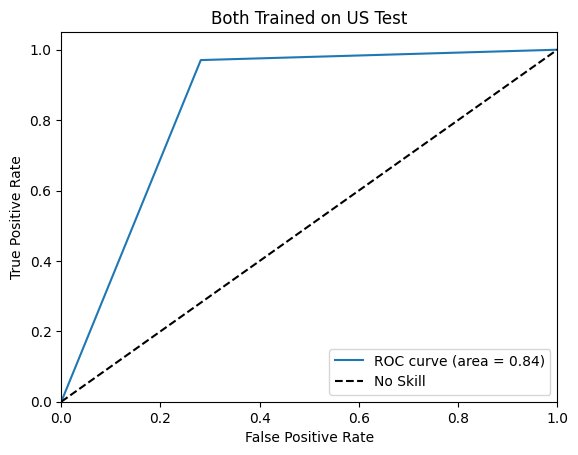

[[23  9]
 [ 1 33]]


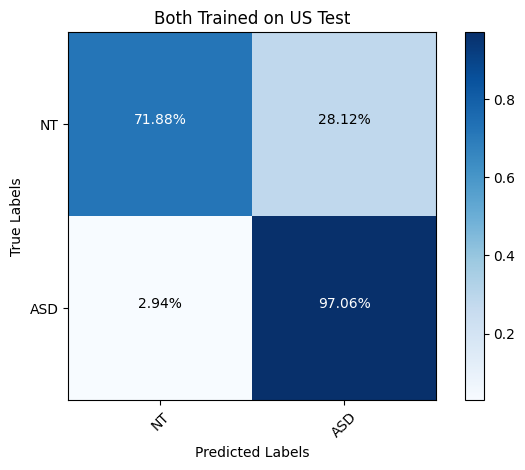

         ROC: 0.8446691176470589
         F1: 0.8684210526315789


In [ ]:
#Both Trained on US Test

#AUC-ROC Score
roc_auc = graph_roc_curve(y_test_us, y_pred_us, 'Both Trained on US Test')

#Building Confusion Matrix
build_cf(y_test_us, y_pred_us, 'Both Trained on US Test')

print("         ROC: " + str(roc_auc))
print("         F1: " + str(f1_score(y_test_us, y_pred_us)))

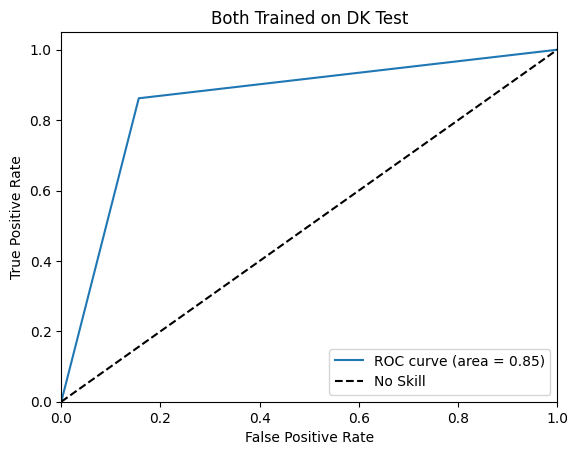

[[81 15]
 [ 8 50]]


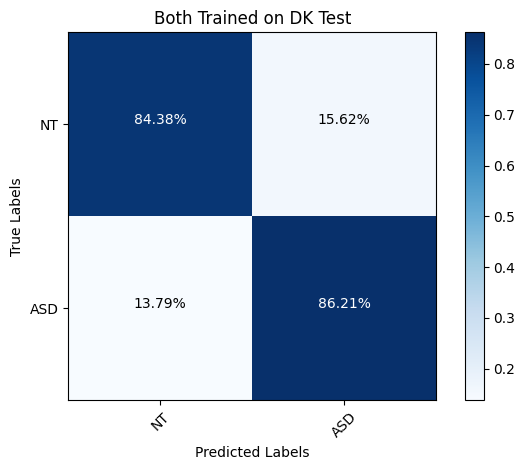

         ROC: 0.8529094827586207
         F1: 0.8130081300813008


In [ ]:
#Both Trained on DK Test

#AUC-ROC Score
roc_auc = graph_roc_curve(y_test_dk, y_pred_dk, 'Both Trained on DK Test')

#Building Confusion Matrix
build_cf(y_test_dk, y_pred_dk, 'Both Trained on DK Test')

print("         ROC: " + str(roc_auc))
print("         F1: " + str(f1_score(y_test_dk, y_pred_dk)))

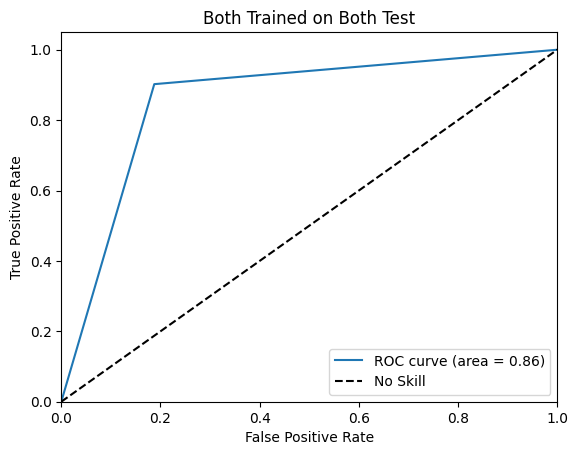

[[104  24]
 [  9  83]]


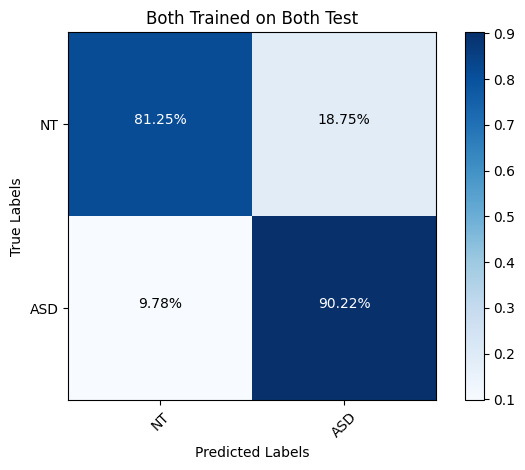

         ROC: 0.8573369565217391
         F1: 0.8341708542713568


In [ ]:
#Both Trained on Both Test

#AUC-ROC Score
roc_auc = graph_roc_curve(y_test_both, y_pred_both, 'Both Trained on Both Test')

#Building Confusion Matrix
build_cf(y_test_both, y_pred_both, 'Both Trained on Both Test')


print("         ROC: " + str(roc_auc))
print("         F1: " + str(f1_score(y_test_both, y_pred_both)))

   Feature  Importance
78     f78       144.0
67     f67        73.0
32     f32        73.0
54     f54        68.0
12     f12        65.0
18     f18        65.0
79     f79        62.0
24     f24        62.0
5       f5        60.0
26     f26        58.0


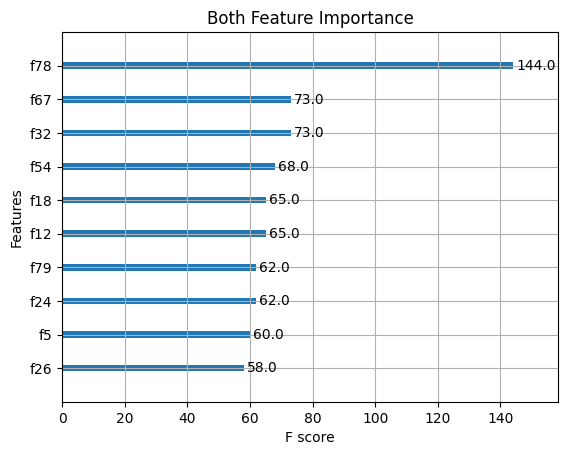

In [ ]:
#graphing most important features when training using both datasets and testing on both datasets
booster = rf.get_booster()
type = 'weight'
importance = booster.get_score(importance_type=type)
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(10))
plot_importance(rf, max_num_features=10, importance_type=type)
plt.title('Both Feature Importance')
f1 = plt.gcf()
plt.show()
f1.savefig('Both Feature Importance.png')

# TRAINED USING ONLY DK DATASET

In [ ]:
rf2 = XGBClassifier(random_state=0, max_depth=8, n_estimators=128, learning_rate=0.1, verbosity=1)
pipeline = Pipeline(steps=[('m',rf2)])
cv = ShuffleSplit(n_splits=5)

In [ ]:
pipeline.fit(x_train_dk, y_train_dk)
y_pred_dk = pipeline.predict(x_test_dk)

In [ ]:
#hypertuning
model = GridSearchCV(rf, {
   'max_depth': [1, 2, 4, 8, 16],
   'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 128, 256, 300, 512],
   'learning_rate': [1, 0.1, 0.01, 0.001],
    'verbosity':[1, 0.1, 0.01]
}, cv=cv, return_train_score=False)
model.fit(x_train_dk, y_train_dk)

print(pd.DataFrame(model.cv_results_))
print(model.best_score_)
print(model.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1446, in fit
    with config_context(verbosity=self.verbosity):
  File "/usr/lib/python3.10/contextlib.py", line 135, in __

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.115297      0.162291         0.007307        0.004952   
1         0.000597      0.000142         0.000000        0.000000   
2         0.000507      0.000069         0.000000        0.000000   
3         0.032981      0.009176         0.004128        0.001851   
4         0.000558      0.000087         0.000000        0.000000   
..             ...           ...              ...             ...   
715       0.000997      0.000764         0.000000        0.000000   
716       0.000423      0.000014         0.000000        0.000000   
717      17.359665      0.657326         0.010795        0.010745   
718       0.002540      0.002939         0.000000        0.000000   
719       0.000995      0.000168         0.000000        0.000000   

    param_learning_rate param_max_depth param_n_estimators param_verbosity  \
0                     1               1                  1               1   
1              

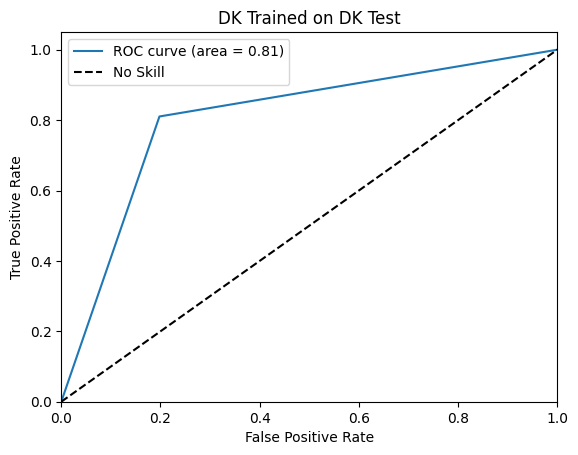

[[77 19]
 [11 47]]


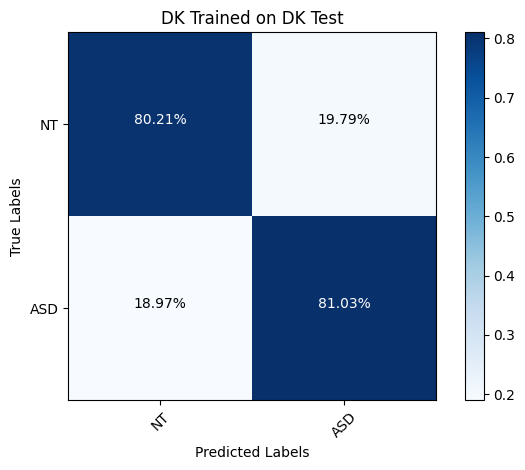

         ROC: 0.80621408045977
         F1: 0.7580645161290323


In [ ]:
#DK Trained on DK Test

#AUC-ROC Score
roc_auc = graph_roc_curve(y_test_dk, y_pred_dk, 'DK Trained on DK Test')

#Building Confusion Matrix
build_cf(y_test_dk, y_pred_dk, 'DK Trained on DK Test')

print("         ROC: " + str(roc_auc))
print("         F1: " + str(f1_score(y_test_dk, y_pred_dk)))

   Feature  Importance
78     f78       113.0
5       f5        70.0
26     f26        58.0
33     f33        56.0
18     f18        56.0
24     f24        55.0
82     f82        53.0
64     f64        49.0
48     f48        43.0
29     f29        42.0


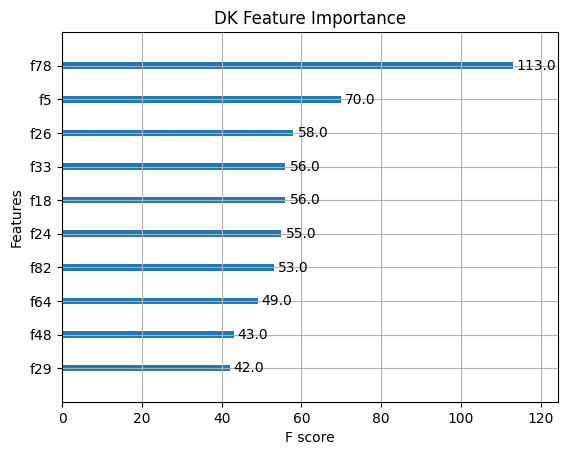

In [ ]:
#graphing most important features when training using DK dataset only
booster = rf2.get_booster()
type = 'weight'
importance = booster.get_score(importance_type=type)
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(10))

plot_importance(rf2, max_num_features=10, importance_type=type)
plt.title('DK Feature Importance')
f1 = plt.gcf()
plt.show()
f1.savefig('DK Feature Importance.png')

# TRAINED USING ONLY US DATASET

In [ ]:
rf3 = XGBClassifier(random_state=0, max_depth=2, n_estimators=128, learning_rate=0.1, verbosity=1)
pipeline = Pipeline(steps=[('m',rf3)])
cv = ShuffleSplit(n_splits=5)

In [ ]:
pipeline.fit(x_train_us, y_train_us)
y_pred_us = pipeline.predict(x_test_us)

In [ ]:
#hypertuning
model = GridSearchCV(rf, {
   'max_depth': [1, 2, 4, 8, 16],
   'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 128, 256, 300, 512],
   'learning_rate': [1, 0.1, 0.01, 0.001],
    'verbosity':[1, 0.1, 0.01]
}, cv=cv, return_train_score=False)
model.fit(x_train_us, y_train_us)

print(pd.DataFrame(model.cv_results_))
print(model.best_score_)
print(model.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1446, in fit
    with config_context(verbosity=self.verbosity):
  File "/usr/lib/python3.10/contextlib.py", line 135, in __

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.130422      0.084131         0.011916        0.007239   
1         0.002226      0.002272         0.000000        0.000000   
2         0.001870      0.002350         0.000000        0.000000   
3         0.031309      0.018642         0.012994        0.006447   
4         0.000602      0.000228         0.000000        0.000000   
..             ...           ...              ...             ...   
715       0.000498      0.000149         0.000000        0.000000   
716       0.000367      0.000021         0.000000        0.000000   
717       6.920342      1.057733         0.003835        0.000224   
718       0.000482      0.000141         0.000000        0.000000   
719       0.000347      0.000006         0.000000        0.000000   

    param_learning_rate param_max_depth param_n_estimators param_verbosity  \
0                     1               1                  1               1   
1              

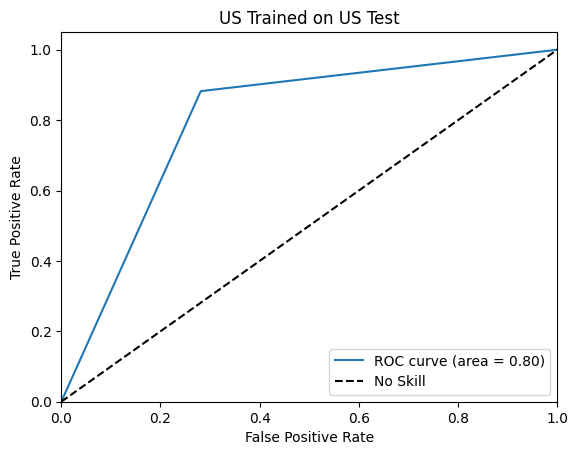

[[23  9]
 [ 4 30]]


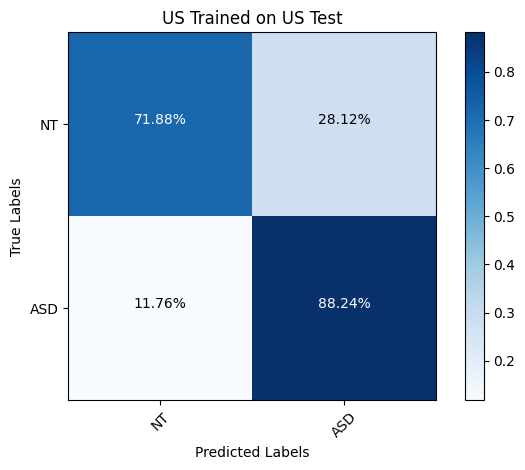

         ROC: 0.8005514705882353
         F1: 0.8219178082191781


In [ ]:
#US Trained on US Test

#AUC-ROC Score
roc_auc = graph_roc_curve(y_test_us, y_pred_us, 'US Trained on US Test')

#Building Confusion Matrix
build_cf(y_test_us, y_pred_us, 'US Trained on US Test')


print("         ROC: " + str(roc_auc))
print("         F1: " + str(f1_score(y_test_us, y_pred_us)))

   Feature  Importance
51     f77        24.0
46     f71        22.0
37     f62        20.0
19     f32        19.0
42     f67        18.0
52     f78        15.0
44     f69        12.0
3       f8        11.0
9      f19        11.0
49     f75        10.0


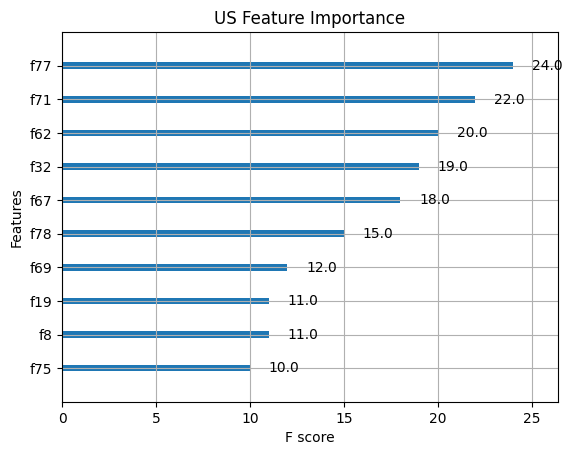

In [ ]:
#graphing most important features when training using US datasets only
booster = rf3.get_booster()
type = 'weight'
importance = booster.get_score(importance_type=type)
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(10))

plot_importance(rf3, max_num_features=10, importance_type=type)
plt.title('US Feature Importance')
f1 = plt.gcf()
plt.show()
f1.savefig('US Feature Importance.png')